# Loading Modules 

In [1]:
import sys
from astropy.table import Table
import numpy as np
import gc
from astropy.io import fits
from astropy.wcs import WCS
from scipy.ndimage import gaussian_filter
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from pathlib import Path
from astropy import units as u
from astropy.time import Time
from astropy.coordinates import SkyCoord
from regions import CircleSkyRegion, RectangleSkyRegion, RectanglePixelRegion, PixCoord
from gammapy.maps import WcsGeom, MapAxis, Map, WcsNDMap
from gammapy.makers import MapDatasetMaker, SafeMaskMaker, FoVBackgroundMaker
from gammapy.data import DataStore
from gammapy.datasets import Datasets, FluxPointsDataset, MapDataset
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel, FoVBackgroundModel, Models, SmoothBrokenPowerLawSpectralModel, Shell2SpatialModel
from gammapy.estimators import FluxPoints,FluxPointsEstimator, ExcessMapEstimator
%matplotlib inline
import sys, os
import numpy as np
import itertools
import re
import datetime
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
import gammapy
import time
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
import json
from pathlib import Path
from astropy import units as u
from astropy.coordinates import SkyCoord
from gammapy.stats import CashCountsStatistic, cash, cash_sum_cython
from gammapy.maps import WcsGeom, MapAxis, Map
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.data import DataStore, Observations
from gammapy.datasets import Datasets, FluxPointsDataset, MapDatasetOnOff
from gammapy.modeling import Fit
from gammapy.modeling.models import SkyModel, LogParabolaSpectralModel, PointSpatialModel, PowerLawSpectralModel, DiskSpatialModel, TemplateSpatialModel, PowerLawNormSpectralModel, BrokenPowerLawSpectralModel, SmoothBrokenPowerLawSpectralModel
from gammapy.datasets import Datasets, MapDataset
from regions import CircleSkyRegion, RectangleSkyRegion, EllipseSkyRegion
from gammapy.estimators import (
    FluxPoints,
    FluxPointsEstimator,
    EnergyDependentMorphologyEstimator)
# from common_utils import get_excluded_regions
#from gammapy.utils.regions import make_region
from gammapy.modeling.models import FoVBackgroundModel, GaussianSpatialModel, ShellSpatialModel, DiskSpatialModel, PiecewiseNormSpectralModel, GeneralizedGaussianSpatialModel, ExpCutoffPowerLawSpectralModel
from gammapy.makers import FoVBackgroundMaker
from gammapy.estimators import ExcessMapEstimator, TSMapEstimator, FluxMaps
from gammapy.maps import WcsNDMap
from gammapy.visualization import plot_npred_signal, plot_distribution
import ipywidgets
from gammapy.modeling.models import Models
from astropy.coordinates import Angle
from collections import OrderedDict
import glob
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import datetime
from scipy.stats import chi2, norm
from astropy.table import Table
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=UserWarning)
DB_general = pd.read_csv('/home/wecapstor1/caph/caph101h/projects/test_projects/Run_matching_tutorial/db_data.csv', header=0)
import sys  
sys.path.insert(1, '/home/hpc/caph/mppi103h/Documents/On-OFF-matching-woody')
from scipy.optimize import curve_fit
from matplotlib.lines import Line2D
from PIL import Image
sys.path.insert(1, '/home/wecapstor1/caph/caph101h/projects/test_projects/Run_matching_tutorial/')
import my_utility_functions as muf
import os
import re
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from astropy import table

In [2]:
from importlib import reload
reload(muf)

<module 'my_utility_functions' from '/home/wecapstor1/caph/caph101h/projects/test_projects/Run_matching_tutorial/my_utility_functions.py'>

In [3]:
PlotDir = '/home/wecapstor1/caph/caph101h/projects/test_projects/2FGL_J1044.5-5737/Plots/Modeling/power_law'

WorkingDir = os.getcwd()

In [4]:
def grid_overlay_in_pixel(_map_to_project_on_, _box_center_, _width_, _height_, _num_rows_, _num_cols_, _row_switch_, _column_switch_, _skiped_regions_=None, _plot_grid_=True, _save_figure_=False):
    """
        Overlays a grid like structure onto a given WcsNDMap.
    
        Parameters:
            - _map_to_project_on_ (WcsNDMap): Map you want your grid to be projected onto.
            - _box_center_ (SkyCoord): Center coordinates you want your grid to be around.
            - _width_ (float): Pixel width size you want your individual box to have.
            - _height_ (float): Pixel height size you want your individual box to have.
            - _num_rows_ (float): Number of rows in the grid.
            - _num_cols_ (float): Number of cols in the grid.
            - _row_switch_ (float): Adjustment for grid in x-direction. Necessary in the case you have chosen _box_center_ to not be in the centre of your FoV.
            - _column_switch_ (float): Adjustment for grid in y-direction. Necessary in the case you have chosen _box_center_ to not be in the centre of your FoV.
            - _skiped_regions_ (array or list): Array containing the regions to be skipped.
            - _plot_grid_ (bool): Whether or not to plot the grid.
            - _save_figure_(bool): Whether or not to save plot.

        Returns:
            - _REGION_LIST_ (list): List containing the individual rectangles (RectanglePixelRegion) that form the grid.   
    """


    ###################################################################### Define Box center ######################################################################
    # First set _box_center_ to be in pixel size. We need to work in terms of pixels, as using SkyRegions makes us work in a spherical coordinate system.
    # Working in such a system is easier, but it is then impossible to have an ordinary aligned grid of boxes (at least from what I tried).
    
    box_center_to_pixel = _box_center_.to_pixel(wcs=_map_to_project_on_.geom.wcs)
    box_center_coordinates = PixCoord(x=box_center_to_pixel[0], y=box_center_to_pixel[1])
    ###############################################################################################################################################################


    ###################################################################### Produce the grid #######################################################################
    # Here we are essentially producing the desired grid through iteration over different x,y offsets.
    # Storing list for the regions:
    _REGION_LIST_ = []

    # Loop through the grid and plot rectangles:
    for idx, (row, col) in enumerate([(r, c) for r in range(_num_rows_) for c in range(_num_cols_)], start=1):
        if np.isin(idx, _skiped_regions_):
            continue
        
        # X offsets for rectangles:
        x_offset = (col - (_num_cols_ - _column_switch_)) * _width_ 
        rectangle_x = box_center_coordinates.x + x_offset  
        
        # Y offsets for rectangles:
        y_offset = (row - (_num_rows_ - _row_switch_)) * _height_
        rectangle_y = box_center_coordinates.y + y_offset

        # Finally make a RectanglePixelRegion and append it to the region list:
        pix_center = PixCoord(x=rectangle_x, y=rectangle_y) 
        region_source = RectanglePixelRegion(pix_center,  width=_width_, height=_height_)
    
        _REGION_LIST_.append(region_source)
    ###############################################################################################################################################################

    
    ################################################################### Plotting the grid & Map ###################################################################
    if _plot_grid_:
        # Set up the figure:
        plt.figure(figsize=(15, 8))
        gs = GridSpec(1, 1) 
        ax1 = plt.subplot(gs[0, 0], projection=_map_to_project_on_.geom.wcs)

        # Set up the map plot you want your grid to be projected on.
        # Make automatic adjustment for the colorbar:
        mask = np.isfinite(_map_to_project_on_.data)
        min_, max_ = round(np.min(_map_to_project_on_.data[mask]), 1), round(np.max(_map_to_project_on_.data[mask]), 1)
        # Plot map and 5σ contours:
        _map_to_project_on_.plot(ax=ax1, add_cbar=True, cmap='coolwarm', vmin=-2, vmax=8)
        ax1.contour(np.squeeze(_map_to_project_on_), levels=[5], colors='green', linewidths=.75)

        # Plot the postion of the box your centered your grid to be working around with:
        marker = {'marker': 'x', 'color': 'black', 'markersize': 5}
        # plot_position(ax1, _box_center_.ra, _box_center_.dec, '', _marker_=marker)

        # Finally plot the rectangles stored in in _REGION_LIST_:
        for idx, region_source in enumerate(_REGION_LIST_, start=1):
            region_source.plot(ax=ax1, edgecolor='black', ls='solid', lw=1)
            ax1.text(region_source.center.x, region_source.center.y, idx, color='black', ha='center', va='center', fontsize=8, weight='bold')
            
        if _save_figure_:
            muf.save_figures(PlotDir, name="Grid_overlay")
        
        plt.show()
    ###############################################################################################################################################################

    return _REGION_LIST_

In [5]:
def spectral_fit(_map_dataset_, _region_list_, _minimal_model_siginificance_,
                 _index_min_, _index_max_, _amplitude_min_, _amplitude_max_,
                 _index_step_=0.5, _amplitude_factor_=10, _labeled_models_=None):
    """
    Automatically selects and fits the best model from the list of labeled models.
    
    Parameters:
        - _map_dataset_ (MapDataset): Dataset you want to work with.
        - _region_list_ (list): List of RectanglePixelRegion type objects you want models for.
        - _minimal_model_siginificance_ (float): Minimal model significance of the model you set onto the regions.
        - _index_min_, _index_max_ (float): Minimal/Maximal index you want to use as starting parameters for spectral_fit.
        - _amplitude_min_, _amplitude_max_ (float): Minimal/Maximal amplitude you want to use as starting parameters for spectral_fit.  
        - _index_step_ (float): Step size for the index to be added on _index_min_, default at 0.5.
        - _amplitude_factor_ (float): Factor that is multiplied with the _amplitude_min_, default at 10.
        - _labeled_models_ (list): List of labeled models that are already defined for fitting, e.g.: [PowerLawSpectralModel, ExpCutoffPowerLawSpectralModel]. If None, uses default models.
    
    Returns:
        - _FIT_RESULTS_DF_ (DataFrame): Dataframe containing:
            - "Region": Index of region in the map for visualization.
            - "Significance": Significance of the best model found.
            - "Sky model": Sky model with highest significance.
            - "Lon_0": Longitude of the rectangle.
            - "Lat_0": Latitude of the rectangle.
        - _GOOD_RESULTS_ (list): List of SpectrumDataset's where the fit process was successful.
        - _BAD_RESULTS_ (list): List of SpectrumDataset's where the fit process was unsuccessful.
    """

    # If no labeled models are provided, fall back to default models
    if _labeled_models_ is None:
        labeled_models = [PowerLawSpectralModel, ExpCutoffPowerLawSpectralModel]
    else:
        labeled_models = _labeled_models_
    
    _FIT_RESULTS_ = []
    _BAD_RESULTS_ = []

    print("Start the fitting...")

    for idx, region in enumerate(_region_list_, start=1):
        region = region.to_sky(wcs=_map_dataset_.counts.geom.wcs)
        
        # Convert the region to a spectrum dataset
        spectrum_dataset_region_with_model = _map_dataset_.to_spectrum_dataset(region)
        spectrum_dataset_region_no_model = _map_dataset_.to_spectrum_dataset(region)
        
        # Parameter bounds
        index_min, index_max = _index_min_, _index_max_
        amplitude_min, amplitude_max = _amplitude_min_, _amplitude_max_

        # Initialize the best model parameters for each region
        best_significance = -float('inf')  # Start with the lowest possible value
        best_sky_model = None
        best_result_dataset = None

        # Iterate over each model class
        for model_class in labeled_models:
            amplitude_ = amplitude_min
            while amplitude_ <= amplitude_max:
                index_ = index_min
                while index_ <= index_max:
                    # Create and fit the model for this region and model class
                    spectral_model_region = model_class(index=index_,
                                                        amplitude=amplitude_ * u.Unit("cm-2 s-1 TeV-1"),
                                                        reference=spectrum_dataset_region_with_model.energy_range_total[0].value * u.TeV)

                    model_region = SkyModel(spectral_model=spectral_model_region, name=f"Model {model_class.__name__} region {idx}")

                    # Assign the model to the dataset
                    spectrum_dataset_region_with_model.models = Models([model_region])

                    # Define the fitting options
                    minuit_opts = {"strategy": 2}

                    # Initialize and run the fit for this region
                    fit_joint_region = Fit(backend="minuit", optimize_opts=minuit_opts)
                    result_region = fit_joint_region.run(datasets=[spectrum_dataset_region_with_model])

                    if result_region.success and result_region.message in ["Optimization terminated successfully."]:
                        # Calculate delta_ts and significance_model
                        delta_ts, significance_model = muf.model_significance(spectrum_dataset_region_with_model, spectrum_dataset_region_no_model, print_result=False)

                        # Check if this is the best model for this region based on significance
                        if significance_model > best_significance:
                            if amplitude_ <= model_region.spectral_model.amplitude.value and index_ <= model_region.spectral_model.index.value:
                                best_significance = significance_model
                                best_sky_model = model_region
                                best_result_dataset = spectrum_dataset_region_with_model.copy()
                                best_result_dataset.models = [best_sky_model]  

                    index_ += _index_step_  # Increment index

                amplitude_ *= _amplitude_factor_  # Increase amplitude for next round

        # Store the best result for this region
        if best_sky_model:
            ra_deg, dec_deg = spectrum_dataset_region_with_model.counts.geom.center_coord[0].value, spectrum_dataset_region_with_model.counts.geom.center_coord[1].value
                
            _FIT_RESULTS_.append({
                "Region": idx,
                "Significance": best_significance,
                "Sky model": best_sky_model,
                "Dataset": best_result_dataset,
                "Lon_0": ra_deg,
                "Lat_0": dec_deg
            })
                
            print(rf"Fit successful for Region {idx}, Significance: {round(best_significance, 2)}σ, Location: {round(ra_deg, 2)}°, {round(dec_deg, 2)}°")
            print(best_sky_model)

        else:
            print(rf"Fit unsuccessful for Region {idx}, Significance: {round(best_significance, 2)}σ, Location: {round(ra_deg, 2)}°, {round(dec_deg, 2)}°")
            print(spectrum_dataset_region_with_model.models[0].spectral_model)
                
            _BAD_RESULTS_.append(spectrum_dataset_region_with_model)

    # Create a DataFrame with fit results
    _FIT_RESULTS_DF_ = pd.DataFrame(_FIT_RESULTS_)
    
    return _FIT_RESULTS_DF_, _BAD_RESULTS_

In [6]:
def sexagesimal_to_ra_dec(ra_sexagesimal, dec_sexagesimal):
    """
    Converts RA and Dec from sexagesimal format (HH:MM:SS, DD:MM:SS) to decimal degrees.
    
    Parameters:
    - ra_sexagesimal: str
        Right Ascension in sexagesimal format (e.g., "07h00m28.8s").
    - dec_sexagesimal: str
        Declination in sexagesimal format (e.g., "+14d19m12.0s").

    Returns:
    - ra: float
        Right Ascension in decimal degrees.
    - dec: float
        Declination in decimal degrees.
    """
    # Create a SkyCoord object from sexagesimal inputs
    sky_coord = SkyCoord(ra=ra_sexagesimal, dec=dec_sexagesimal, frame='icrs')
    
    # Extract RA and Dec in decimal degrees
    ra = sky_coord.ra.deg
    dec = sky_coord.dec.deg
    
    return ra, dec

def convert_to_hms_dms(ra_deg, dec_deg):
    """
    Convert Right Ascension (RA) and Declination (Dec) from degrees 
    to hh:mm:ss and dd:mm:ss formats, respectively.

    Parameters:
    ra_deg (float): Right Ascension in degrees.
    dec_deg (float): Declination in degrees.

    Returns:
    tuple: A tuple containing:
           - RA in hh:mm:ss format (str)
           - Dec in dd:mm:ss format (str)
    """
    # Create a SkyCoord object for the J2000 coordinates
    coord_j2000 = SkyCoord(ra=ra_deg * u.deg, dec=dec_deg * u.deg, frame='icrs')

    # Convert R.A. and Dec. to hh:mm:ss and dd:mm:ss format
    ra_hms = coord_j2000.ra.to_string(unit=u.hour, sep=':')
    dec_dms = coord_j2000.dec.to_string(unit=u.deg, sep=':', alwayssign=True)

    return ra_hms, dec_dms


def chi_squared_calculator(_flux_points_, _sky_model_, _num_fit_params_):
    """
    Calculate chi-squared between observed flux points and model predictions.

    Parameters:
    - flux_points: FluxPoints object containing the observed flux points data.
    - model: Spectral model object to compare with flux points.
    - delta_e: Small energy range around each flux point for flux prediction (default: 0.1 TeV).
    
    Returns:
    - chi2_values: List of chi-squared values for each flux point.
    """
    # Extract the observed flux and energy data
    energy_axis = flux_points.energy_axis
    
    mask = np.isfinite(_flux_points_.e2dnde.data[:, 0, 0])  # Filter out non-finite values
    observed_flux = flux_points.e2dnde.data[mask][:, 0, 0]  # Observed flux values
    observed_flux_error = _flux_points_.e2dnde_err.data[mask][:, 0, 0]  # Observed flux values
    
    predicted_flux = _sky_model_.spectral_model.reference_fluxes(energy_axis)["ref_e2dnde"] * u.Unit("cm2 s / TeV")

    normalisation = np.max(observed_flux)
    
    observed_flux_normed = observed_flux/normalisation
    observed_flux_error_normed = observed_flux_error/normalisation
    predicted_flux_normed = predicted_flux/normalisation

    chi2 = np.sum((observed_flux_normed - predicted_flux_normed)**2/observed_flux_error_normed**2)

    degrees_of_freedom = len(observed_flux_normed) - _num_fit_params_
    
    chi2_reduced = chi2/degrees_of_freedom
    
    return chi2, chi2_reduced

def source_regions_plot(_ax_, _catalog_, _marker_):
    """
    Plot all sources within 4 deg of ra, dec = (160.81, -58.85)
    """
    for index in range(len(_catalog_.table)):
        ra = _catalog_.table[index]["RAJ2000"]
        dec = _catalog_.table[index]["DEJ2000"]
        name = _catalog_.table[index]["Source_Name"]

        position = SkyCoord(ra, dec, frame='icrs', unit='deg')
        # _ax_.text(position.ra.deg+.75, position.dec.deg+.1, name, weight='bold',color=_marker_['color'],transform=_ax_.get_transform('world'))
        _ax_.plot(position.ra.deg, position.dec.deg, **_marker_, transform=_ax_.get_transform('world'))

def plot_spectrum(model, flux_points=None, energy_power=2, label=None, color=None, plot_type="both"):
    """
    Plots the spectral model and/or flux points.

    Parameters:
    - model: Spectral model to plot.
    - flux_points: Flux points to plot. If None, only the model spectrum will be plotted.
    - energy_power: Power of energy for scaling (e.g., 2 for E^2 dN/dE). Default is 2.
    - label: Label for the plot.
    - color: Color for the plot.
    - plot_type: What to plot ("both", "model", "flux_points"). Default is "both".
    """
    spec = model.spectral_model
    energy_range = [0.1, 100] * u.TeV

    # Plot the model spectrum
    if plot_type in ("both", "model"):
        spec.plot(energy_bounds=energy_range,energy_power=energy_power,label=label,color=color)
        # Uncomment to plot errors if needed
        spec.plot_error(energy_bounds=energy_range, energy_power=energy_power, color=color)
    
    # Plot the flux points if provided
    if flux_points is not None and plot_type in ("both", "flux_points"):
        flux_points.plot(energy_power=energy_power, color=color)
        
        # Label the flux points if only plotting them
        if plot_type == "flux_points":
            flux_points.plot(energy_power=energy_power, color=color, label=label)
    
    # Set the ylabel dynamically based on energy_power
    if energy_power == 0:
        plt.ylabel(r'dN/dE [TeV cm$^{-2}$ s$^{-1}$]')
    else:
        plt.ylabel(r'E$^{%d}$ dN/dE [TeV cm$^{-2}$ s$^{-1}$]' % energy_power)

In [7]:
def chi2_asymmetric(_flux_points_):
    """
    Calculate chi-squared with asymmetric errors.
    
    Parameters:
    data : array-like
        Observed data points.
        
    Returns:
    chi2 : float
        Chi-squared value.
    """

    spec_model = _flux_points_.reference_model.spectral_model

    free_model_params = len(spec_model.parameters.free_parameters)
    
    dof = len(_flux_points_.to_table()) - free_model_params

    # Extract the observed flux and energy data
    energy_axis = _flux_points_.energy_axis

    mask = np.isfinite(_flux_points_.e2dnde.data[:, 0, 0]) 
    observed_flux = _flux_points_.e2dnde.data[mask][:, 0, 0]
    observed_flux_error_up = _flux_points_.e2dnde_errp.data[mask][:, 0, 0]
    observed_flux_error_low = _flux_points_.e2dnde_errn.data[mask][:, 0, 0]    
    
    predicted_flux = spec_model.reference_fluxes(energy_axis)["ref_e2dnde"] * u.Unit("cm2 s / TeV")

    normalisation = np.max(observed_flux)
    
    observed_flux_normed = observed_flux/normalisation
    predicted_flux_normed = predicted_flux/normalisation
    
    observed_flux_error_up_normed = observed_flux_error_up/normalisation
    observed_flux_error_low_normed = observed_flux_error_low/normalisation    

    chi2 = 0
    for y_data, y_model, err_low, err_up in zip(observed_flux_normed, predicted_flux_normed, observed_flux_error_low_normed, observed_flux_error_up_normed):
        if y_model > y_data:
            chi2 += ((y_data - y_model) ** 2) / (err_up ** 2)
        else:
            chi2 += ((y_data - y_model) ** 2) / (err_low ** 2)

    reduced_chi2 = chi2/dof
    
    return chi2, reduced_chi2

In [8]:
def plot_position(_ax_, ra, dec, name, _marker_):
    
    position = SkyCoord(ra, dec, frame='icrs', unit='deg')
    _ax_.text(position.ra.deg, position.dec.deg-.3, name, weight='bold',color=_marker_['color'],transform=_ax_.get_transform('world'))
    _ax_.plot(position.ra.deg, position.dec.deg, **_marker_, transform=_ax_.get_transform('world'))

def make_template_spatial_model(_dataset_):
    masked_counts =  _dataset_.excess * _dataset_.mask_safe
    # masked_counts =  _dataset_.excess.sum_over_axes().smooth(.25*u.deg) * _dataset_.mask_safe.sum_over_axes()
    
    epsilon = 1e-10  # Small value to avoid zeros
    spatial_data = masked_counts.data
    spatial_data[spatial_data < 0] = epsilon

    collapsed_map_data = spatial_data.sum(axis=0)

    collapsed_map = Map.from_geom(masked_counts.geom.to_image(), data=collapsed_map_data)

    spatial_model = TemplateSpatialModel(map=collapsed_map, normalize=True)

    return spatial_model

def make_template_spatial_model_from_excess(_result_):
    # Retrieve the excess map
    excess_map = _result_.npred_excess
    
    # Apply the spatial and energy mask
    masked_excess_map = excess_map 
    
    # Collapse over energy axis
    collapsed_map_data = masked_excess_map.sum_over_axes().data
    
    # Replace negative values with a small constant
    epsilon = 1e-10
    collapsed_map_data[collapsed_map_data < 0] = epsilon
    
    # Create a 2D spatial map
    collapsed_map = Map.from_geom(masked_excess_map.geom.to_image(), data=collapsed_map_data)
    
    # Generate the TemplateSpatialModel
    spatial_model = TemplateSpatialModel(map=collapsed_map, normalize=True)
    
    return spatial_model

In [9]:
def plot_ngc_3324(_ax_, _marker_):
    ra = 159.33331995
    dec = -58.6416623
    name = "NGC 3324"
    
    position = SkyCoord(ra, dec, frame='icrs', unit='deg')
    _ax_.text(position.ra.deg+1.25, position.dec.deg+.05, name, weight='bold',color=_marker_['color'],transform=_ax_.get_transform('world'))
    _ax_.plot(position.ra.deg, position.dec.deg, **_marker_, transform=_ax_.get_transform('world'))

# Helper function to convert number to Roman numeral
def to_roman(n):
    roman_numerals = {
        1: 'I', 2: 'II', 3: 'III', 4: 'IV', 5: 'V', 6: 'VI', 7: 'VII', 8: 'VIII', 9: 'IX', 10: 'X',
        11: 'XI', 12: 'XII', 13: 'XIII', 14: 'XIV', 15: 'XV', 16: 'XVI', 17: 'XVII', 18: 'XVIII', 19: 'XIX', 20: 'XX'
    }
    return roman_numerals.get(n, str(n))  # Default if out of range


# Inspecting the MapDataset

In [10]:
from gammapy.catalog import CATALOG_REGISTRY, SourceCatalog4FGL, SourceCatalog, SourceCatalog3HWC, SourceCatalogGammaCat, SourceCatalogHGPS, SourceCatalog3FHL

catalog_4FGL = SourceCatalog4FGL('/home/wecapstor1/caph/caph101h/software/miniforge3/bin/gammapy-datasets/1.2/catalogs/fermi/gll_psc_v32.fit.gz')
source_fermi_J1044 = catalog_4FGL["4FGL J1036.3-5833e"]
mask_roi = source_fermi_J1044.position.separation(catalog_4FGL.positions) < 2.5 * u.deg

catalog_4FGL_roi = catalog_4FGL[mask_roi]
print("Number of sources :", len(catalog_4FGL_roi.table))

non_source_models = []
for models in catalog_4FGL_roi.to_models():
    if models.name != "4FGL J1044.4-5737" and models.name != "4FGL J1048.2-5832" and models.name != "4FGL J1048.5-5923":
    # if models.name != "4FGL J1044.4-5737" and models.name != "4FGL J1048.2-5832":
        models.parameters.freeze_all()
        non_source_models.append(models)

Number of sources : 15


In [11]:
# dataset_fov = MapDataset.read('/home/vault/caph/caph101h/datasets/2FGL_J1044_point_5_5737/stacked_fov_bkg_wide_fov_finer_binning_periastron_runs_taken_out.fits.gz')
dataset_fov = MapDataset.read('/home/vault/caph/caph101h/datasets/2FGL_J1044_point_5_5737/stacked_fov_bkg_wide_fov_periastron_runs_and_runs_above_nsb_mean_eq_200_taken_out.fits.gz')

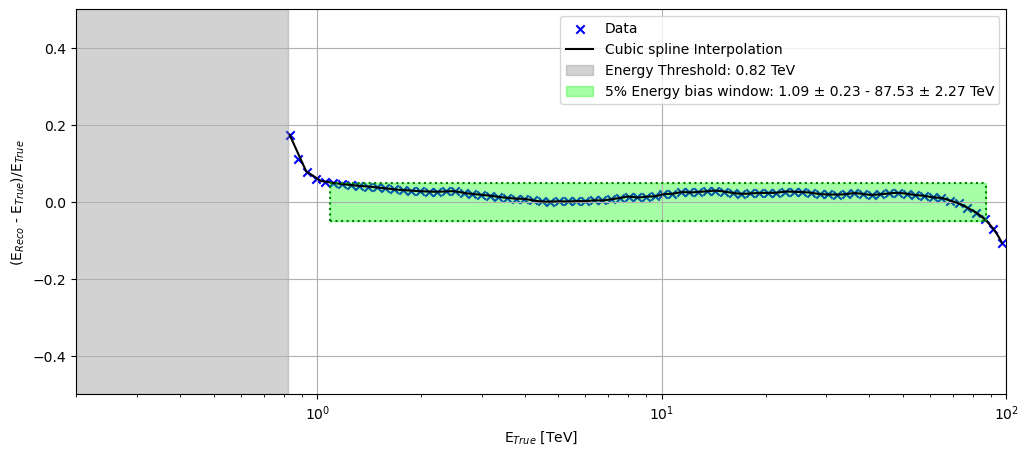

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
from scipy.misc import derivative  # Import derivative for error propagation

# Obtain energy and bias data
energy = np.array(dataset_fov.edisp.get_edisp_kernel().axes["energy_true"].center)
energy_min = dataset_fov.energy_range_total[0].value
bias = np.array(dataset_fov.edisp.get_edisp_kernel().get_bias(energy))

mask = (energy >= energy_min)

# Filtered data
x = energy[mask]
y = bias[mask]

# Create a cubic spline interpolation function with extrapolation
f_cubic = interp1d(x, y, kind='cubic', fill_value='extrapolate')

# Function to find the energy corresponding to bias values and calculate errors
def find_energy(target_bias, initial_guess):
    energy_found = fsolve(lambda x: f_cubic(x) - target_bias, initial_guess)[0]
    
    # Calculate the derivative at the found energy
    energy_derivative = derivative(f_cubic, energy_found, dx=1e-6)  # Small change in energy
    bias_error = 0.01  # Example: assume a 1% uncertainty in bias
    energy_error = abs(bias_error / energy_derivative)  # Propagate the error

    return energy_found, energy_error

# Find energies and errors for bias 0.05 and bias 0
bias_energy_below_5_percent_low, error_low = find_energy(0.05, initial_guess=1.0)
bias_energy_below_5_percent_high, error_high = find_energy(-0.05, initial_guess=70.0)

# Plotting
plt.figure(figsize=(12, 5))

# Scatter plot of bias data
plt.scatter(x, y, marker ='x', label='Data', color='blue')

# Interpolation plot
x_new = np.linspace(min(x), max(x), 1000)
y_new = f_cubic(x_new)
plt.plot(x_new, y_new, label='Cubic spline Interpolation', color='black')

# Energy threshold area
plt.axvspan(xmin=0, xmax=dataset_fov.energy_range_total[0].value, color='grey', alpha=.35, label=f'Energy Threshold: {round(dataset_fov.energy_range_total[0].value, 2)} TeV')

# Vertical lines for bias energy thresholds
plt.vlines(bias_energy_below_5_percent_low, -0.05, 0.05, ls=':', color='green')
plt.vlines(bias_energy_below_5_percent_high, -0.05, 0.05, ls=':', color='green')

# Horizontal lines for bias threshold
plt.hlines(0.05, bias_energy_below_5_percent_low, bias_energy_below_5_percent_high, ls=':', color='green')
plt.hlines(-0.05, bias_energy_below_5_percent_low, bias_energy_below_5_percent_high, ls=':', color='green')

# Label for the bias window
label_box = (f'5% Energy bias window: {round(bias_energy_below_5_percent_low, 2)} ± {round(error_low, 2)} - 'f'{round(bias_energy_below_5_percent_high, 2)} ± {round(error_high, 2)} TeV')
plt.axvspan(xmin=bias_energy_below_5_percent_low, xmax=bias_energy_below_5_percent_high, ymin=0.45, ymax=.55, color='lime', alpha=.35, label=label_box)

# Set limits and labels
plt.xlim(2e-1, 1e2)
plt.ylim(-0.5, 0.5)
plt.xlabel('E$_{True}$ [TeV]')
plt.ylabel(r'(E$_{Reco}$ - E$_{True}$)/E$_{True}$')
plt.legend()
plt.grid()
plt.xscale('log')

plt.show()

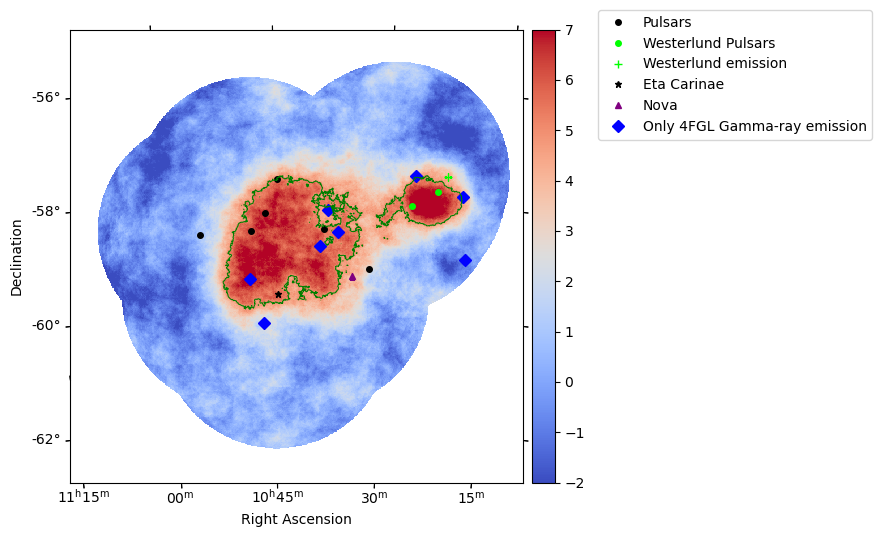

In [13]:
cor_rad = .6*u.deg

# estimator_edges_1 = ExcessMapEstimator(correlation_radius = cor_rad, energy_edges=[dataset_fov.energy_range_total[0].value, bias_energy_below_5_percent_low, bias_energy_below_5_percent_high] * u.TeV)
# result_1 = estimator_edges_1.run(dataset_fov)
# result_1.sqrt_ts.plot_grid(figsize=(15, 6), cmap="coolwarm", add_cbar=True, vmin=-2, vmax=7)
# plt.show()

estimator_edges_2 = ExcessMapEstimator(correlation_radius = cor_rad, energy_edges=[bias_energy_below_5_percent_low, bias_energy_below_5_percent_high] * u.TeV)
result_2 = estimator_edges_2.run(dataset_fov)

plt.figure(figsize=(30, 20))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  

ax1=plt.subplot(gs[0, 0], projection=result_2.sqrt_ts.geom.wcs)

result_2.sqrt_ts.plot(ax1, cmap="coolwarm", add_cbar=True, vmin=-2, vmax=7)

marker_psr = dict(marker='o', color='black', markersize=4)
plot_position(ax1, 162.05, -58.54, '', marker_psr) # PSR B1046-58
plot_position(ax1, 161.58, -58.23, '', marker_psr) # PSR B1044-57
plot_position(ax1, 163.78, -58.58, '', marker_psr) # PSR J1057-5851
plot_position(ax1, 161.14, -57.63, '', marker_psr) # PSR J1044-5737
plot_position(ax1, 159.58, -58.52, '', marker_psr) # PSR B1036-58
plot_position(ax1, 158.02, -59.20, '', marker_psr) # PSR B1030-58


marker_westerlund_psr = dict(marker='o', color='lime', markersize=4)
marker_westerlund = dict(marker='+', color='lime', markersize=6)
plot_position(ax1, 155.81, -57.78, '', marker_westerlund_psr) # PSR J1023-5746 # Westerlund 2 extended region
plot_position(ax1, 156.65, -58.06, '', marker_westerlund_psr) # PSR J1028-5819 # Westerlund 2 extended region
plot_position(ax1, 155.53, -57.51, '', marker_westerlund) # Cl Westerlund 2

marker_eta_car = dict(marker='*', color='black', markersize=5)
plot_position(ax1, 161.15, -59.67, '', marker_eta_car) # Eta Carinae

marker_nova = dict(marker='^', color='purple', markersize=4)
plot_position(ax1, 158.59, -59.34, '', marker_nova) # V* V906 Car -- Classical Nova

# marker_blazar = dict(marker='o', color='orange', markersize=4)
# plot_position(ax1, 161.29, -55.03, '', marker_blazar) # 4FGL J1047.2-5517 -- Blazar Candidate
# plot_position(ax1, 165.20, -56.21, '', marker_blazar) # 4FGL J1102.9-5628 -- Blazar Candidate


# Define legend handles for each marker type
legend_handles = [
    Line2D([0], [0], marker='o', color='black', markersize=4, linestyle='None', label='Pulsars'),
    Line2D([0], [0], marker='o', color='lime', markersize=4, linestyle='None', label='Westerlund Pulsars'),
    Line2D([0], [0], marker='+', color='lime', markersize=6, linestyle='None', label='Westerlund emission'),
    Line2D([0], [0], marker='*', color='black', markersize=5, linestyle='None', label='Eta Carinae'),
    Line2D([0], [0], marker='^', color='purple', markersize=4, linestyle='None', label='Nova'),
    Line2D([0], [0], marker='D', color='blue', markersize=6, linestyle='None', label='Only 4FGL Gamma-ray emission'),
]

# Add the legend to the plot
ax1.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.15, 0.9))

associated_sources_dict = {"Pulsar": ["4FGL J1048.2-5832", "4FGL J1044.4-5737", "4FGL J1023.0-5745", "4FGL J1028.5-5819", "4FGL J1056.9-5852"],
                           "Nova": ["4FGL J1036.2-5936"],
                           "Blazar Candidate": ["4FGL J1047.2-5517", "4FGL J1102.9-5628"],
                           "Westerlund Extended": ["4FGL J1023.3-5747e"],
                           "Eta Carinae": ["4FGL J1045.1-5940"]}
 
# associated_sources description:
#     4FGL J1048.2-5832: PSR B1046-58 162.05, -58.54
#     4FGL J1044.4-5737: PSR B1044-57 161.58, -58.23
#     4FGL J1023.0-5745: PSR J1023-5746 155.81, -57.78
#     4FGL J1028.5-5819: PSR J1028-5819 156.65, -58.06
#     4FGL J1056.9-5852: PSR J1057-5851 163.78, -58.58
#     --               : PSR J1044-5737 161.14, -57.63
#     --               : PSR B1036-58 159.58, -58.52
#     --               : PSR B1030-58 158.02, -59.20

#     4FGL J1045.1-5940 Eta Carinae -- Blue Supergiant 	160.78 ,-59.42
#     4FGL J1023.3-5747e: Cl Westerlund 2 155.53, -57.51

#     4FGL J1036.2-5936: V* V906 Car -- Classical Nova 158.59, -59.34
#     4FGL J1047.2-5517: 4FGL J1047.2-5517 -- Blazar Candidate 161.29,-55.03
#     4FGL J1102.9-5628: 4FGL J1102.9-5628 -- Blazar Candidate 165.20, -56.21

marker_unassociated_sources = dict(marker='D', color='blue', markersize=6)


for models in catalog_4FGL_roi.to_models():
    # Check if the source is associated
    is_associated = any(
        models.name in source_list for source_list in associated_sources_dict.values()
    )

    if not is_associated:  
        plot_position(ax1, models.spatial_model.lon_0.value, models.spatial_model.lat_0.value, '', marker_unassociated_sources) 

ax1.contour(np.squeeze(result_2.sqrt_ts), levels=[5], colors='green', linewidths = .75)

plt.show()

# Modelling grid

## Overview

In [33]:
dataset_001 = dataset_fov.copy()

centre_region_1 = SkyCoord(160.13, -58.55, unit="deg", frame="icrs")
region_1 = RectangleSkyRegion(centre_region_1, width=4*u.deg, height=4*u.deg)

# dataset_001 = dataset_001.cutout(SkyCoord(162.05, -58.54, unit="deg", frame="icrs"), width=2*u.deg)

region_1_mask = dataset_001.counts.geom.region_mask(region_1)

bias_energy_below_5_percent_low = 1.16

energy_mask = dataset_001.counts.geom.energy_mask(energy_min=bias_energy_below_5_percent_low * u.TeV, energy_max=bias_energy_below_5_percent_high * u.TeV)

dataset_001.mask_fit = energy_mask #* region_1_mask

print(f'Analysing energy range from {dataset_001.energy_range_total[0].value} TeV to {dataset_001.energy_range_total[1].value} TeV')

Analysing energy range from 1.1689518164985782 TeV to 79.12342618981327 TeV


In [38]:
estimator = ExcessMapEstimator(correlation_radius=0.6*u.deg, energy_edges=[bias_energy_below_5_percent_low, bias_energy_below_5_percent_high]*u.TeV)
result = estimator.run(dataset_001)

significance_map = result.sqrt_ts
npred_excess_map = result.npred_excess
npred_excess_data = np.squeeze(npred_excess_map)
significance_data = np.squeeze(significance_map)

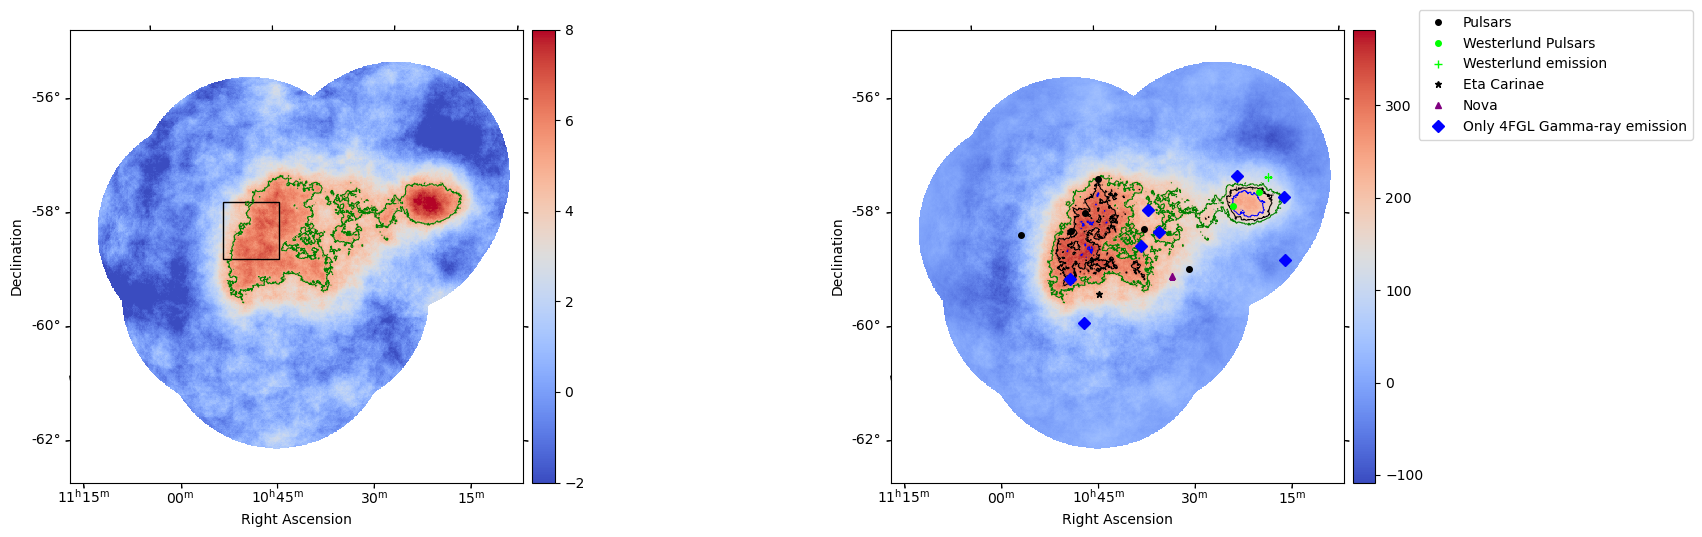

In [16]:
plt.figure(figsize=(30, 20))
gs = GridSpec(3, 3, height_ratios=[1, 1, 1])  

centre_region_1 = SkyCoord(162.05, -58.54, unit="deg", frame="icrs").to_pixel(wcs=significance_map.geom.wcs)
pix_centre = PixCoord(x=centre_region_1[0], y=centre_region_1[1])
region_1 = RectanglePixelRegion(pix_centre,  width=100, height=100)

ax1=plt.subplot(gs[0, 0], projection=significance_map.geom.wcs)

region_1.plot(ax=ax1, edgecolor='black', ls='solid')

significance_map.plot(ax=ax1, add_cbar=True, cmap='coolwarm', vmin=-2, vmax=8)
ax1.contour(significance_data, levels=[5], colors='green', linewidths = .75)

ax2=plt.subplot(gs[0, 1], projection=npred_excess_map.geom.wcs)

# region_1.plot(ax=ax2, edgecolor='black', ls='solid')

npred_excess_map.plot(ax=ax2, add_cbar=True, cmap='coolwarm')
ax2.contour(significance_data, levels=[5, 6, 7], colors=['green', 'black', 'blue'], linewidths = .75)

marker_psr = dict(marker='o', color='black', markersize=4)
plot_position(ax2, 162.05, -58.54, '', marker_psr) # PSR B1046-58
plot_position(ax2, 161.58, -58.23, '', marker_psr) # PSR B1044-57
plot_position(ax2, 163.78, -58.58, '', marker_psr) # PSR J1057-5851
plot_position(ax2, 161.14, -57.63, '', marker_psr) # PSR J1044-5737
plot_position(ax2, 159.58, -58.52, '', marker_psr) # PSR B1036-58
plot_position(ax2, 158.02, -59.20, '', marker_psr) # PSR B1030-58


marker_westerlund_psr = dict(marker='o', color='lime', markersize=4)
marker_westerlund = dict(marker='+', color='lime', markersize=6)
plot_position(ax2, 155.81, -57.78, '', marker_westerlund_psr) # PSR J1023-5746 # Westerlund 2 extended region
plot_position(ax2, 156.65, -58.06, '', marker_westerlund_psr) # PSR J1028-5819 # Westerlund 2 extended region
plot_position(ax2, 155.53, -57.51, '', marker_westerlund) # Cl Westerlund 2

marker_eta_car = dict(marker='*', color='black', markersize=5)
plot_position(ax2, 161.15, -59.67, '', marker_eta_car) # Eta Carinae

marker_nova = dict(marker='^', color='purple', markersize=4)
plot_position(ax2, 158.59, -59.34, '', marker_nova) # V* V906 Car -- Classical Nova

# marker_blazar = dict(marker='o', color='orange', markersize=4)
# plot_position(ax2, 161.29, -55.03, '', marker_blazar) # 4FGL J1047.2-5517 -- Blazar Candidate
# plot_position(ax2, 165.20, -56.21, '', marker_blazar) # 4FGL J1102.9-5628 -- Blazar Candidate


# Define legend handles for each marker type
legend_handles = [
    Line2D([0], [0], marker='o', color='black', markersize=4, linestyle='None', label='Pulsars'),
    Line2D([0], [0], marker='o', color='lime', markersize=4, linestyle='None', label='Westerlund Pulsars'),
    Line2D([0], [0], marker='+', color='lime', markersize=6, linestyle='None', label='Westerlund emission'),
    Line2D([0], [0], marker='*', color='black', markersize=5, linestyle='None', label='Eta Carinae'),
    Line2D([0], [0], marker='^', color='purple', markersize=4, linestyle='None', label='Nova'),
    Line2D([0], [0], marker='D', color='blue', markersize=6, linestyle='None', label='Only 4FGL Gamma-ray emission'),
]

# Add the legend to the plot
ax2.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.15, 0.9))

associated_sources_dict = {"Pulsar": ["4FGL J1048.2-5832", "4FGL J1044.4-5737", "4FGL J1023.0-5745", "4FGL J1028.5-5819", "4FGL J1056.9-5852"],
                           "Nova": ["4FGL J1036.2-5936"],
                           "Blazar Candidate": ["4FGL J1047.2-5517", "4FGL J1102.9-5628"],
                           "Westerlund Extended": ["4FGL J1023.3-5747e"],
                           "Eta Carinae": ["4FGL J1045.1-5940"]}
 
# associated_sources description:
#     4FGL J1048.2-5832: PSR B1046-58 162.05, -58.54
#     4FGL J1044.4-5737: PSR B1044-57 161.58, -58.23
#     4FGL J1023.0-5745: PSR J1023-5746 155.81, -57.78
#     4FGL J1028.5-5819: PSR J1028-5819 156.65, -58.06
#     4FGL J1056.9-5852: PSR J1057-5851 163.78, -58.58
#     --               : PSR J1044-5737 161.14, -57.63
#     --               : PSR B1036-58 159.58, -58.52
#     --               : PSR B1030-58 158.02, -59.20

#     4FGL J1045.1-5940 Eta Carinae -- Blue Supergiant 	160.78 ,-59.42
#     4FGL J1023.3-5747e: Cl Westerlund 2 155.53, -57.51

#     4FGL J1036.2-5936: V* V906 Car -- Classical Nova 158.59, -59.34
#     4FGL J1047.2-5517: 4FGL J1047.2-5517 -- Blazar Candidate 161.29,-55.03
#     4FGL J1102.9-5628: 4FGL J1102.9-5628 -- Blazar Candidate 165.20, -56.21

marker_unassociated_sources = dict(marker='D', color='blue', markersize=6)


for models in catalog_4FGL_roi.to_models():
    # Check if the source is associated
    is_associated = any(
        models.name in source_list for source_list in associated_sources_dict.values()
    )

    if not is_associated:  
        plot_position(ax2, models.spatial_model.lon_0.value, models.spatial_model.lat_0.value, '', marker_unassociated_sources) 

# muf.save_figures("/home/wecapstor1/caph/caph101h/projects/test_projects/2FGL_J1044.5-5737/Plots/Modeling/", name='region_of_interest_4p23TeV')

plt.show()

## Modelling

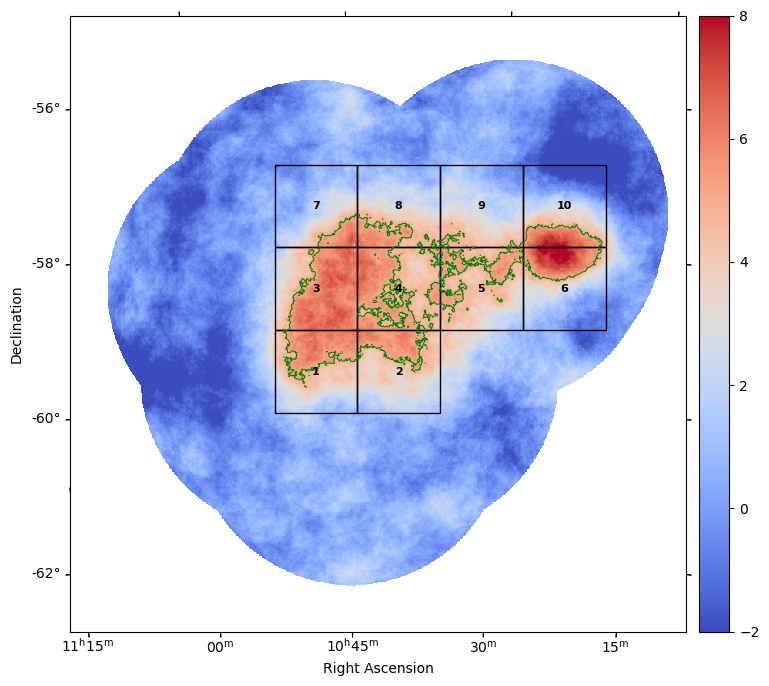

In [18]:
psr_B1046_58_location = SkyCoord(162.05, -58.54, unit="deg", frame="icrs")
center = SkyCoord(160.05, -59, unit="deg", frame="icrs")
region_list = grid_overlay_in_pixel(_map_to_project_on_=significance_map, _box_center_=psr_B1046_58_location, 
                                    _width_=107.5, _height_=107.5,
                                    _num_rows_=3, _num_cols_=4,
                                    _row_switch_=2, _column_switch_=4,
                                    _skiped_regions_=[3, 4],
                                    _plot_grid_=True,
                                    _save_figure_=True
                                   )

# westerlund_2 = SkyCoord(155.81, -57.78, unit="deg", frame="icrs")
# region_w2 = grid_overlay_in_pixel(_map_to_project_on_=significance_map, _box_center_=westerlund_2, 
#                                     _width_=32, _height_=32,
#                                     _num_rows_=1, _num_cols_=1,
#                                     _row_switch_=1, _column_switch_=1,
#                                     # _skiped_regions_=[]
#                                     _plot_grid_=True
#                                    )

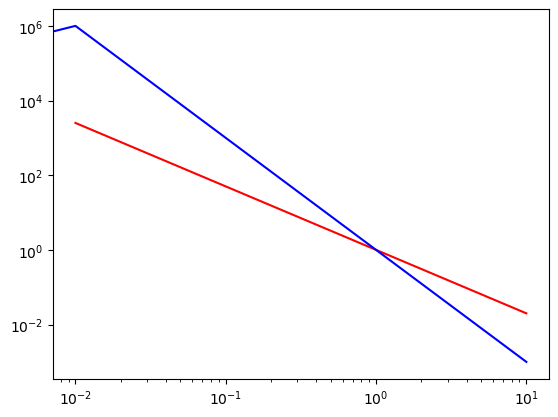

In [19]:
x = np.linspace(-10, 10, 1000)

fig, ax = plt.subplots()

plt.plot(x, x**-1.7, color='red')
plt.plot(x, x**-3, color='blue')

plt.yscale("log")
plt.xscale("log")

plt.show()

In [20]:
fit_results_df, bad_results = spectral_fit(_map_dataset_=dataset_001,
                                                         _region_list_=region_list,
                                                         _minimal_model_siginificance_=1,
                                                         _index_min_=1.5,
                                                         _index_max_=3,
                                                         _amplitude_min_=1e-14,
                                                         _amplitude_max_=1e-10)

Start the fitting...
Fit successful for Region 1, Significance: 4.42σ, Location: 162.1°, -59.62°
SkyModel

  Name                      : Model PowerLawSpectralModel region 1
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      3.155   +/-    0.47             
    amplitude                     :   2.54e-12   +/- 6.9e-13 1 / (TeV s cm2)
    reference             (frozen):      1.169       TeV         


Fit successful for Region 2, Significance: 3.92σ, Location: 159.98°, -59.62°
SkyModel

  Name                      : Model PowerLawSpectralModel region 2
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      3.305   +/-    0.83             
    amplitude                     :   2.61e-12   +/- 

In [21]:
print("Total fitted regions:", len(fit_results_df))
print("Non fitable regions:", len(bad_results))
print(bad_results)

print("\n")


for idx, row in enumerate(fit_results_df.itertuples(index=False), start=1):
    datasets = row.Dataset
    significance = row.Significance
    print(f"Region {idx}, Significance {round(significance, 2)}")
    print(datasets.models.to_parameters_table())
    print("\n")

Total fitted regions: 10
Non fitable regions: 0
[]


Region 1, Significance 4.42
               model                 type    name     value         unit        error   min max frozen is_norm link prior
------------------------------------ ---- --------- ---------- -------------- --------- --- --- ------ ------- ---- -----
Model PowerLawSpectralModel region 1          index 3.1552e+00                4.693e-01 nan nan  False   False           
Model PowerLawSpectralModel region 1      amplitude 2.5361e-12 TeV-1 s-1 cm-2 6.932e-13 nan nan  False    True           
Model PowerLawSpectralModel region 1      reference 1.1690e+00            TeV 0.000e+00 nan nan   True   False           


Region 2, Significance 3.92
               model                 type    name     value         unit        error   min max frozen is_norm link prior
------------------------------------ ---- --------- ---------- -------------- --------- --- --- ------ ------- ---- -----
Model PowerLawSpectralModel region 

In [130]:
estimator = ExcessMapEstimator(correlation_radius=0.6*u.deg, energy_edges=[bias_energy_below_5_percent_low, bias_energy_below_5_percent_high]*u.TeV)
result = estimator.run(dataset_001)

significance_map = result.sqrt_ts

significance_map = significance_map.cutout(center, width=(6, 4)*u.deg) 

significance_data = np.squeeze(significance_map)

In [54]:
# Load the TS map from the FITS file
ts_file = "ts10.fits"
with fits.open(ts_file) as hdul:
    ts_data = hdul[0].data  # Extract the data array
    ts_header = hdul[0].header  # Extract the WCS header

# Create a WCS object from the header
ts_wcs = WCS(ts_header)

# Smooth the TS data
smoothed_ts_data = gaussian_filter(ts_data, sigma=2.97)

# Define the contour levels and colors
contour_levels = [3.0, 4.0, 5.0]
contour_color = "black"

Set MJD-END to 57176.988647 from DATE-END'. [astropy.wcs.wcs]


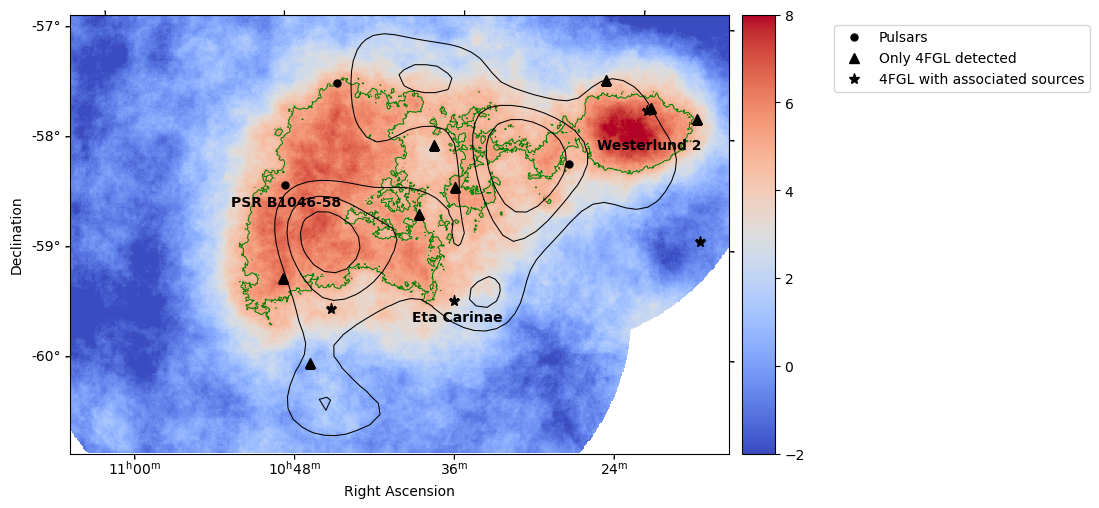

In [137]:
plt.figure(figsize=(20, 8))
gs = GridSpec(1, 2) 
ax1 = plt.subplot(gs[0, 0], projection=significance_map.geom.wcs)
ax1.contour(significance_data, levels=[5], colors='green', linewidths=.75)
significance_map.plot(ax=ax1, add_cbar=True, cmap='coolwarm', vmin=-2, vmax=8)

marker_psr = dict(marker='o', color='black', markersize=5)
plot_position(ax1, 157.12, -58.32, '', marker_psr) # PSR J1028-5819
plot_position(ax1, 161.14, -57.62, '', marker_psr) # PSR J1044-5737 
plot_position(ax1, 162.05, -58.54, '', marker_psr) # PSR B1046-58 


psr_sources = ["4FGL J1028.5-5819", "4FGL J1044.4-5737", "4FGL J1048.2-5832"]

associated_source = ["4FGL J1018.9-5856", "4FGL J1023.3-5747e", "4FGL J1036.2-5936", "4FGL J1045.1-5940"]

marker_4fgl_unassociated_sources = dict(marker='^', color='black', markersize=7)
marker_4fgl_associated_sources = dict(marker='*', color='black', markersize=8)

for models in catalog_4FGL_roi.to_models():
    if (models.name not in psr_sources) & (models.name not in associated_source):
        plot_position(ax1, models.spatial_model.lon_0.value, models.spatial_model.lat_0.value, '', marker_4fgl_unassociated_sources)
    elif models.name in associated_source:
        plot_position(ax1, models.spatial_model.lon_0.value, models.spatial_model.lat_0.value, '', marker_4fgl_associated_sources)       

legend_handles = [
    Line2D([0], [0], marker='o', color='black', markersize=5, linestyle='None', label='Pulsars'),
    Line2D([0], [0], marker='^', color='black', markersize=7, linestyle='None', label='Only 4FGL detected'),
    Line2D([0], [0], marker='*', color='black', markersize=8, linestyle='None', label='4FGL with associated sources')
]

ax1.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.15, 0.9))

ax1.contour(smoothed_ts_data, transform=ax1.get_transform(ts_wcs), levels=contour_levels, colors=contour_color, linewidths=0.75)

ax1.text(162.05, -58.7, "PSR B1046-58", color='black', transform=ax1.get_transform('world'), ha='center', va='center', fontsize=10, weight='bold')
ax1.text(159, -59.75, "Eta Carinae", color='black', transform=ax1.get_transform('world'), ha='center', va='center', fontsize=10, weight='bold')
ax1.text(155.75, -58.1, "Westerlund 2", color='black', transform=ax1.get_transform('world'), ha='center', va='center', fontsize=10, weight='bold')

# muf.save_figures(PlotDir, name="map_with_contours_from_paper")

plt.show()

In [ ]:
plt.figure(figsize=(20, 8))
gs = GridSpec(1, 2) 

# empty_map = Map.from_geom(geom=significance_map.geom, data=np.zeros_like(significance_map))

# ax2 = plt.subplot(gs[0, 1], projection=empty_map.geom.wcs)
# white_cmap = ListedColormap(['white'])
# empty_map.plot(ax=ax2, cmap=white_cmap)

# ax2.contour(significance_data, levels=[5], colors='lime', linewidths=1.5)

# # Extract energy_flux values from the dataframe
# energy_flux_values = []
# index_val_list = []

# # Calculate the energy flux for each row in the dataframe
# for idx, row in fit_results_df.iterrows():
#     sky_model = row["Sky model"]
    
#     energy_flux = sky_model.spectral_model.energy_flux(energy_min=bias_energy_below_5_percent_low * u.TeV, energy_max=bias_energy_below_5_percent_high * u.TeV) * 1.6022
#     energy_flux_values.append(energy_flux.value)  # Store the flux as a float value

#     index_vals = sky_model.spectral_model.index.value
#     index_val_list.append(index_vals)

# # Normalize the energy flux values to map them to the colormap
# norm = Normalize(vmin=np.min(energy_flux_values), vmax=np.max(energy_flux_values))

# norm_index = Normalize(vmin=np.min(index_val_list), vmax=np.max(index_val_list))

# # Choose a colormap (you can choose others like 'viridis', 'coolwarm', etc.)
# cmap = plt.get_cmap('coolwarm_r')

# # Create a ScalarMappable to map normalized values to colors
# sm = ScalarMappable(cmap=cmap, norm=norm_index)

# # Now, plot the rectangles with colors based on energy flux
# for idx, row in fit_results_df.iterrows():
#     sky_model = row["Sky model"]
#     lon_0 = row["Lon_0"]
#     significance = row["Significance"]
#     lat_0 = row["Lat_0"]
#     label = idx + 1

    
#     # Extract the corresponding energy flux from the list (based on idx)
#     energy_flux_value = energy_flux_values[idx] 

#     index_val = sky_model.spectral_model.index.value
    
#     # Map the energy flux to a color using the colormap
#     # color = sm.to_rgba(energy_flux_value)
#     color = sm.to_rgba(index_val)
    
#     # Get the region from the region list and plot it with the color based on energy flux
#     region = region_list[idx].to_sky(wcs=empty_map.geom.wcs)
#     region_source = region.to_pixel(wcs=empty_map.geom.wcs)
#     region_source.plot(ax=ax2, edgecolor='black', facecolor=color, fill=True, ls='solid', lw=1)
#     # ax2.text(region.center.ra.value, region.center.dec.value, label, color='black', transform=ax2.get_transform('world'), ha='center', va='center', fontsize=8, weight='bold')
    

# marker_psr = dict(marker='o', color='black', markersize=5)
# plot_position(ax2, 157.12, -58.32, '', marker_psr) # PSR J1028-5819
# plot_position(ax2, 161.14, -57.62, '', marker_psr) # PSR J1044-5737 
# plot_position(ax2, 162.05, -58.54, '', marker_psr) # PSR B1046-58 


# psr_sources = ["4FGL J1028.5-5819", "4FGL J1044.4-5737", "4FGL J1048.2-5832"]

# associated_source = ["4FGL J1018.9-5856", "4FGL J1023.3-5747e", "4FGL J1036.2-5936", "4FGL J1045.1-5940"]

# marker_4fgl_unassociated_sources = dict(marker='^', color='black', markersize=7)
# marker_4fgl_associated_sources = dict(marker='*', color='black', markersize=8)

# for models in catalog_4FGL_roi.to_models():
#     if (models.name not in psr_sources) & (models.name not in associated_source):
#         plot_position(ax2, models.spatial_model.lon_0.value, models.spatial_model.lat_0.value, '', marker_4fgl_unassociated_sources)
#     elif models.name in associated_source:
#         plot_position(ax2, models.spatial_model.lon_0.value, models.spatial_model.lat_0.value, '', marker_4fgl_associated_sources)       

# legend_handles = [
#     Line2D([0], [0], marker='o', color='black', markersize=5, linestyle='None', label='Pulsars'),
#     Line2D([0], [0], marker='^', color='black', markersize=7, linestyle='None', label='Only 4FGL detected'),
#     Line2D([0], [0], marker='*', color='black', markersize=8, linestyle='None', label='4FGL with associated sources')
# ]

# ax2.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1.15, 0.9))

# ax2.text(162.05, -58.7, "PSR B1046-58", color='black', transform=ax2.get_transform('world'), ha='center', va='center', fontsize=10, weight='bold')
# ax2.text(159, -59.75, "Eta Carinae", color='black', transform=ax2.get_transform('world'), ha='center', va='center', fontsize=10, weight='bold')
# ax2.text(155.75, -58.1, "Westerlund 2", color='black', transform=ax2.get_transform('world'), ha='center', va='center', fontsize=10, weight='bold')

# cbar = plt.colorbar(sm, ax=ax2)
# # cbar.set_label(r'Energy Flux [erg cm$^{-2}$ s$^{-1}$]', fontsize = 14)
# cbar.set_label(r'Index', fontsize = 14)
# plt.tight_layout()

# muf.save_figures(PlotDir, name="grid_heat_map_index")

# plt.show()

## Flux Profile

In [24]:
for idx, datasets in enumerate(fit_results_df["Dataset"], start=1):
    if idx == 3:
        dataset_3 = datasets

In [25]:
energy_axis = dataset_001.counts.geom.axes["energy"].edges[21:59:8]
energy_axis = [
    1.16895182,
    2.35983347, 
    6.02089449,
    12.1547425,
    21.82644728,
]*u.TeV

print(energy_axis)

fpe = FluxPointsEstimator(energy_edges=energy_axis, source=dataset_3.models.names[0], selection_optional={"all"})
flux_points_region_3 = fpe.run(datasets=dataset_3)

print(len(flux_points_region_3.to_table()))

[ 1.16895182  2.35983347  6.02089449 12.1547425  21.82644728] TeV
4


In [26]:
flux_points_region_3.to_table()

<Table length=4>
      e_ref              e_min              e_max               ref_dnde               ref_flux       ... is_ul   counts   success                 stat_scan                         norm_scan        
       TeV                TeV                TeV            1 / (TeV s cm2)          1 / (s cm2)      ...                                                                                             
     float64            float64            float64              float64                float64        ...  bool float64[1]   bool                 float64[11]                       float64[11]       
------------------ ------------------ ------------------ ---------------------- --------------------- ... ----- ---------- ------- ------------------------------------------ ------------------------
1.6608827826277157 1.1689518164985782 2.3598334667821947  7.224351809285737e-13 8.496889032973882e-13 ... False     1613.0    True  -14913.79330946368 .. -14790.672468448654 0.2 .. 4.999999999999999
3.7693909753883625 2.3598334667821947  6.020894493336132 1.6674068287231948e-13 5.992289080634521e-13 ... False      891.0    True   -6748.749709646644 .. -6568.147405115185 0.2 .. 4.999999999999999
 8.554672535565683  6.020894493336132 12.154742500762868  3.138300922799539e-14 1.920796282147462e-13 ... False      202.0    True  -1019.0260121608761 .. -946.5378068957281 0.2 .. 4.999999999999999
16.287874214985496 12.154742500762868  21.82644728397485  6.241352544860443e-15 6.130917655431384e-14 ...  True       60.0    True -182.18890059383244 .. -137.23629535424777 0.2 .. 4.999999999999999

In [27]:
index_0 = 0
index_1 = 30

energy = flux_points_region_3.energy_ref.value[index_0:index_1]
energy_range = [energy - flux_points_region_3.energy_min.value[index_0:index_1], flux_points_region_3.energy_max.value[index_0:index_1] - energy]

e2dnde = flux_points_region_3.e2dnde.data[:,0][:,0][index_0:index_1]*1.6022
e2dnde_err = flux_points_region_3.e2dnde_err.data[:,0][:,0][index_0:index_1]*1.6022

reference_model_energy = flux_points_region_3.reference_model.spectral_model.reference_fluxes(dataset_001.counts.geom.axes["energy"])["e_ref"].value
reference_model_e2dnde = flux_points_region_3.reference_model.spectral_model.reference_fluxes(dataset_001.counts.geom.axes["energy"])["ref_e2dnde"].value * 1.6022
reference_model_e2dnde_err = flux_points_region_3.reference_model.spectral_model.evaluate_error(flux_points_region_3.reference_model.spectral_model.reference_fluxes(dataset_001.counts.geom.axes["energy"])["e_ref"])[1].value*reference_model_energy**2 * 1.6022
reference_model_e2dnde_errn = reference_model_e2dnde - reference_model_e2dnde_err
reference_model_e2dnde_errp = reference_model_e2dnde_err + reference_model_e2dnde

free_model_params = len(flux_points_region_3.reference_model.spectral_model.parameters.free_parameters)
    
chi2_value, red_chi2_value = chi2_asymmetric(flux_points_region_3)

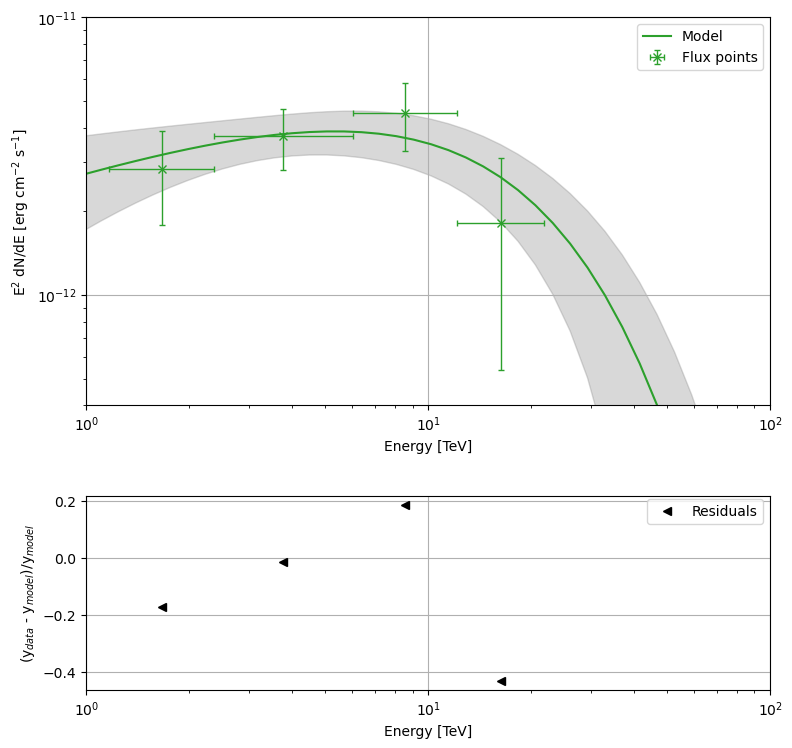

In [28]:
plt.figure(figsize=(30, 20))
gs = GridSpec(3, 3, height_ratios=[.5, .25, 1])  

ax1 = plt.subplot(gs[0, 0])

ax1.errorbar(energy, e2dnde, xerr=energy_range, yerr=e2dnde_err, fmt='x', color='tab:green', ecolor='tab:green', elinewidth=1, capsize=2, label=f"Flux points")#, χ²/dof = {red_chi2_value:.2f}")
ax1.plot(reference_model_energy, reference_model_e2dnde, color='tab:green', label = 'Model')
ax1.fill_between(reference_model_energy, reference_model_e2dnde_errn, reference_model_e2dnde_errp,  color="gray",  alpha=0.3)

ax1.set_xlabel('Energy [TeV]')
ax1.set_ylabel(r'E$^2$ dN/dE [erg cm$^{-2}$ s$^{-1}$]')

ax1.set_xlim(1e-0, 1e2)
ax1.set_ylim(4e-13, 1e-11)

ax1.set_xscale('log')
ax1.set_yscale('log')

ax1.legend()
ax1.grid()


ax2 = plt.subplot(gs[1,0])

eaxis_residuals = MapAxis.from_energy_bounds(energy[0]*u.TeV, energy[-1]*u.TeV, len(energy))
reference_e2dnde_for_residuals = flux_points_region_3.reference_model.spectral_model.reference_fluxes(eaxis_residuals)["ref_e2dnde"].value*1.6022

residuals = (e2dnde - reference_e2dnde_for_residuals)/reference_e2dnde_for_residuals

ax2.plot(energy, residuals, '<', color='black', label='Residuals')

ax2.set_xscale("log")
ax2.set_xlim(xmin=1e0,xmax=1e2)
# ax2.set_ylim(ymin=-1,ymax=1)

ax2.legend(bbox_to_anchor=(1,1.02))
ax2.set_xlabel("Energy [TeV]")
ax2.set_ylabel(r'(y$_{data}$ - y$_{model}$)/y$_{model}$')
ax2.grid()

# muf.save_figures(PlotDir, name="flux_points")

plt.show()

In [29]:
data_table = Table([energy, energy_range[0], energy_range[1], e2dnde, e2dnde_err], 
            names=('energy', 'energy_edge_low', 'energy_edge_high', 'e2dnde', 'e2dnde_err'))

data_table['energy'].unit = u.TeV
data_table['energy_edge_low'].unit = u.TeV
data_table['energy_edge_high'].unit = u.TeV
data_table['e2dnde'].unit = u.Unit('erg / (cm2 s)')  
data_table['e2dnde_err'].unit = u.Unit('erg / (cm2 s)') 

print(data_table)

# data_table.write('/home/wecapstor1/caph/caph101h/projects/test_projects/2FGL_J1044.5-5737/Analysis/Power_law/energy_flux_data.ecsv', format='ascii.ecsv', overwrite = True)

      energy         energy_edge_low    energy_edge_high          e2dnde               e2dnde_err      
       TeV                 TeV                TeV             erg / (s cm2)          erg / (s cm2)     
------------------ ------------------- ------------------ ---------------------- ----------------------
1.6608827826277157 0.49193096612913756  0.698950684154479 2.8470127880825924e-12 1.0549363409404312e-12
3.7693909753883625  1.4095575086061678 2.2515035179477696 3.7484124096026036e-12  9.416672848304046e-13
 8.554672535565683  2.5337780422295504 3.6000699651971857  4.533653173762699e-12 1.2371141373936038e-12
16.287874214985496   4.133131714222628  5.538573068989354 1.8201068207268708e-12 1.2857271498481433e-12
